# Final Project
Zhiyu Tu

1-You must create a simple web API to predict a user's BMI in real-time. You can also use webcam input. The goal is to use one of the pre-trained image models (e.g. VGG Face), fine-tune with the provided data, and deploy via jupyter notebook, streamlit, flask or any other simple restful api's.

2-10 pages of the write-up about your implementation.

3-10 mins presentation or live demo in the final lecture.

Our goal is to beat the performance metrics provided in the paper.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
from PIL import Image, ImageOps
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
img_path = '/content/drive/MyDrive/Machine_Learning_Final/Images'
data_path = '/content/drive/MyDrive/Machine_Learning_Final/data.csv'

data = pd.read_csv(data_path)
data.drop('Unnamed: 0', axis=1, inplace=True)
print(data.shape)
data.head()

(4206, 4)


,bmi,gender,is_training,name
0,34.207396,Male,1,img_0.bmp
1,26.453720,Male,1,img_1.bmp
2,34.967561,Female,1,img_2.bmp
3,22.044766,Female,1,img_3.bmp
4,37.758789,Female,1,img_4.bmp


In [3]:
images = os.listdir(img_path)
print(len(images)) 

3963


In [4]:
data = data.loc[data['name'].isin(images)]

In [5]:
train = data[data['is_training'] == 1]
test = data[data['is_training'] == 0]
print(train.shape)
print(test.shape)

(3210, 4)
(752, 4)


In [6]:
y_train = train['bmi']
y_test = test['bmi']

In [7]:
train_path = '/content/drive/MyDrive/Machine_Learning_Final/train'
test_path = '/content/drive/MyDrive/Machine_Learning_Final/test'

# for name in train['name']:
#     src = img_path+ '/' + name
#     shutil.copy(src, train_path)

# for name in test['name']:
#     src = img_path + '/' + name
#     shutil.copy(src, test_path)

In [7]:
import tensorflow as tf
from tensorflow import keras
from keras import Model
from keras.utils import load_img, img_to_array, image_dataset_from_directory, array_to_img
from keras.preprocessing import image
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential
from keras import layers

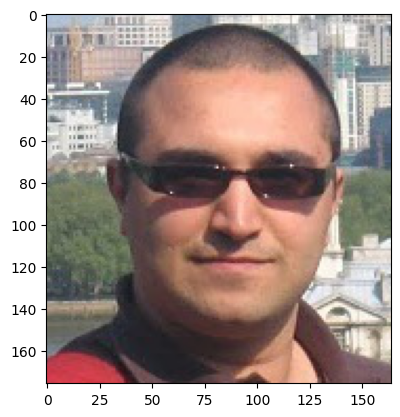

In [9]:
train_img_paths = sorted([os.path.join(train_path, imgname) for imgname in os.listdir(train_path) ])
test_img_paths = sorted([os.path.join(test_path, imgname)for imgname in os.listdir(test_path) ])
plt.imshow(load_img(train_img_paths[0]));

In [10]:
img_to_array(load_img(train_img_paths[0])).shape

(176, 164, 3)

In [11]:
import cv2
def resize_img(path):
  resize_img = img_to_array(load_img(path,target_size=(224,224)))
  return resize_img

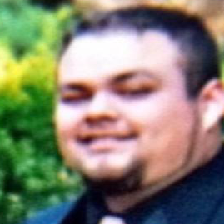

In [25]:
array_to_img(resize_img(train_img_paths[100]))

In [14]:
train_len = train.shape[0]
test_len = test.shape[0]
input_imgs = np.zeros((train_len,224,224,3), dtype="float32")
for i in range(train_len):
    input_imgs[i] = resize_img(train_img_paths[i])

test_imgs = np.zeros((test_len,224,224,3), dtype="float32")
for i in range(test_len):
    test_imgs[i] = resize_img(test_img_paths[i])

print(input_imgs.shape)
print(test_imgs.shape)

(3210, 224, 224, 3)
(752, 224, 224, 3)


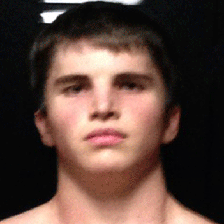

In [15]:
array_to_img(input_imgs[732])

## NN

In [3]:
!pip install keras_vggface
!pip install keras_applications 
!pip install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 5.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import keras_vggface
from keras_vggface.vggface import VGGFace
# keras.utils.layer_utils import get_source_inputs

In [ ]:
def define_model(model = 'vgg16'):

    if model == 'vgg16':
        vgg_face = VGGFace(model=model, include_top=False, input_shape=(224,224,3), pooling = 'avg') 
        vgg_last_layer = vgg_face.output
    elif model == 'resnet50':
        vgg_face = VGGFace(model=model, include_top=False, input_shape=(224,224,3), pooling = 'avg')
        vgg_last_layer = vgg_face.output
    elif model == 'senet50':
        vgg_face = VGGFace(model=model, include_top=False, input_shape=(224,224,3), pooling = 'avg')
        vgg_last_layer = vgg_face.output


    # transfer learning
    for layer in vgg_face.layers:
        layer.trainable = False
    x = layers.Dense(1024, activation = 'relu')(vgg_last_layer)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(512, activation = 'relu')(x)
    x = layers.Dense(64, activation = 'relu')(x)
    bmi_out = layers.Dense(1, activation = 'linear')(x)
    model = Model(vgg_face.input, bmi_out)
    model.compile(optimizer='adam', loss='mae')

    return model

tf.config.list_physical_devices('GPU')

### VGG16

In [10]:
model_vgg16 = define_model()
model_vgg16.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1_1 (Conv2D)            (None, 224, 224, 64)      1792      
                                                                 
 conv1_2 (Conv2D)            (None, 224, 224, 64)      36928     
                                                                 
 pool1 (MaxPooling2D)        (None, 112, 112, 64)      0         
                                                                 
 conv2_1 (Conv2D)            (None, 112, 112, 128)     73856     
                                                                 
 conv2_2 (Conv2D)            (None, 112, 112, 128)     147584    
                                                                 
 pool2 (MaxPooling2D)        (None, 56, 56, 128)       0   

In [20]:
es = EarlyStopping(patience=5, restore_best_weights= True)
callbacks = [es]
model_vgg16.fit(input_imgs, y_train, batch_size=128, epochs=30, validation_split=0.2, callbacks=callbacks)

Epoch 1/30
21/21 [==============================] - 1522s 73s/step - loss: 9.3471 - val_loss: 8.9561
Epoch 2/30
21/21 [==============================] - 1500s 72s/step - loss: 7.8093 - val_loss: 8.2196
Epoch 3/30
21/21 [==============================] - 1474s 71s/step - loss: 8.2725 - val_loss: 8.2675
Epoch 4/30
21/21 [==============================] - 1458s 70s/step - loss: 7.6262 - val_loss: 8.9633
Epoch 5/30
21/21 [==============================] - 1484s 71s/step - loss: 7.3029 - val_loss: 7.8367
Epoch 6/30
21/21 [==============================] - 1458s 70s/step - loss: 7.5504 - val_loss: 7.5592
Epoch 7/30
21/21 [==============================] - 1449s 70s/step - loss: 7.3168 - val_loss: 7.7622
Epoch 8/30
21/21 [==============================] - 1452s 70s/step - loss: 7.3588 - val_loss: 7.8126
Epoch 9/30
21/21 [==============================] - 1456s 70s/step - loss: 7.4524 - val_loss: 7.9561
Epoch 10/30
21/21 [==============================] - 1450s 70s/step - loss: 7.0148 - val_lo

In [21]:
model_vgg16.save('/content/drive/MyDrive/Machine_Learning_Final/model/model.h5')

In [22]:
model_vgg16.evaluate(test_imgs, y_test, batch_size=128)

6/6 [==============================] - 332s 55s/step - loss: 8.2618


8.261807441711426

In [23]:
bmi_pred = model_vgg16.predict(test_imgs)
bmi_pred = bmi_pred.reshape(-1)

24/24 [==============================] - 332s 14s/step


In [24]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

print(f'Test RMSE = {mean_squared_error(y_test, bmi_pred)**0.5}')
print(f'Test MAE = {mean_absolute_error(y_test, bmi_pred)}')

Test RMSE = 11.143005020003732
Test MAE = 8.261807311032491


### RESNET50

In [48]:
model_resnet = define_model(model='resnet50')
model_resnet.summary()

94694792/94694792 [==============================] - 2s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1/7x7_s2 (Conv2D)          (None, 112, 112, 64  9408        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 conv1/7x7_s2/bn (BatchNormaliz  (None, 112, 112, 64  256        ['conv1/7x7_s2[0][0]']           
 ation)                    

In [50]:
es = EarlyStopping(patience=5, restore_best_weights= True)
callbacks = [es]
model_resnet.fit(input_imgs, y_train, batch_size=128, epochs=30, validation_split=0.2,callbacks=callbacks)
model_resnet.save('/content/drive/MyDrive/Machine_Learning_Final/model/model_resnet.h5')

Epoch 1/30
21/21 [==============================] - 622s 30s/step - loss: 6.7687 - val_loss: 7.4705
Epoch 2/30
21/21 [==============================] - 613s 30s/step - loss: 6.5873 - val_loss: 7.2189
Epoch 3/30
21/21 [==============================] - 614s 30s/step - loss: 6.3854 - val_loss: 8.3808
Epoch 4/30
21/21 [==============================] - 613s 29s/step - loss: 6.3062 - val_loss: 7.9929
Epoch 5/30
21/21 [==============================] - 612s 29s/step - loss: 5.9633 - val_loss: 7.3881
Epoch 6/30
21/21 [==============================] - 614s 29s/step - loss: 6.1619 - val_loss: 7.7937
Epoch 7/30
21/21 [==============================] - 613s 30s/step - loss: 6.1085 - val_loss: 6.9858
Epoch 8/30
21/21 [==============================] - 615s 30s/step - loss: 6.2177 - val_loss: 8.1250
Epoch 9/30
21/21 [==============================] - 591s 28s/step - loss: 5.8970 - val_loss: 7.6458
Epoch 10/30
21/21 [==============================] - 616s 30s/step - loss: 5.5579 - val_loss: 7.3536

In [51]:
model_resnet.evaluate(test_imgs, y_test, batch_size=128)

6/6 [==============================] - 140s 23s/step - loss: 7.5022


7.502211570739746

In [52]:
bmi_pred_resnet = model_resnet.predict(test_imgs).reshape(-1)

24/24 [==============================] - 139s 6s/step


In [53]:
print(f'Test RMSE = {mean_squared_error(y_test, bmi_pred_resnet)**0.5}')
print(f'Test MAE = {mean_absolute_error(y_test, bmi_pred_resnet)}')

Test RMSE = 10.013671386159578
Test MAE = 7.502211712424094


### SENET50

In [26]:
model_senet50 = define_model(model='senet50')
model_senet50.summary()

104944616/104944616 [==============================] - 2s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1/7x7_s2 (Conv2D)          (None, 112, 112, 64  9408        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv1/7x7_s2/bn (BatchNormaliz  (None, 112, 112, 64  256        ['conv1/7x7_s2[0][0]']           
 ation)                  

In [27]:
es = EarlyStopping(patience=5, restore_best_weights= True)
callbacks = [es]
model_senet50.fit(input_imgs, y_train, batch_size=128, epochs=30, validation_split=0.2, callbacks=callbacks)
model_senet50.save('/content/drive/MyDrive/Machine_Learning_Final/model/model_senet50.h5')

Epoch 1/30
21/21 [==============================] - 420s 20s/step - loss: 12.6601 - val_loss: 9.6615
Epoch 2/30
21/21 [==============================] - 470s 23s/step - loss: 7.1771 - val_loss: 8.0691
Epoch 3/30
21/21 [==============================] - 411s 20s/step - loss: 6.8039 - val_loss: 7.4453
Epoch 4/30
21/21 [==============================] - 410s 20s/step - loss: 6.7352 - val_loss: 9.6144
Epoch 5/30
21/21 [==============================] - 410s 20s/step - loss: 6.6378 - val_loss: 8.3833
Epoch 6/30
21/21 [==============================] - 408s 20s/step - loss: 6.5659 - val_loss: 10.3639
Epoch 7/30
21/21 [==============================] - 409s 20s/step - loss: 6.4397 - val_loss: 8.1179
Epoch 8/30
21/21 [==============================] - 410s 20s/step - loss: 6.3059 - val_loss: 11.0520


In [28]:
model_senet50.evaluate(test_imgs, y_test, batch_size=128)

6/6 [==============================] - 95s 16s/step - loss: 8.3787


8.378716468811035

In [29]:
bmi_pred_senet = model_senet50.predict(test_imgs).reshape(-1)

24/24 [==============================] - 96s 4s/step


In [30]:
print(f'Test RMSE = {mean_squared_error(y_test, bmi_pred_senet)**0.5}')
print(f'Test MAE = {mean_absolute_error(y_test, bmi_pred_senet)}')

Test RMSE = 11.694007083807566
Test MAE = 8.37871706517299
